In [1]:
#!pip install unrar


In [2]:
#!unrar x PetImages.zip image/

In [3]:
!wget https://www.dropbox.com/s/9n62h06fc7u2z7a/train.zip?dl=1  -O train.zip

--2023-10-20 09:14:19--  https://www.dropbox.com/s/9n62h06fc7u2z7a/train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9n62h06fc7u2z7a/train.zip [following]
--2023-10-20 09:14:20--  https://www.dropbox.com/s/dl/9n62h06fc7u2z7a/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7609715bb3b58d1bef64bada8b.dl.dropboxusercontent.com/cd/0/get/CF9QxspUStkbG4d7C_ciIYjTCCOfTzrY88p_otCBISnfk-5RHNjT2su8pQQ9MnUnLjLNwwFzz7WPdL4lpLRtu_r3YFILOePDCOD2cgRs7-0I5uK3BiTYlX_E1yXByzq2Pr-Z5O_NYPvJ_BjLUTPw-JjR/file?dl=1# [following]
--2023-10-20 09:14:20--  https://uc7609715bb3b58d1bef64bada8b.dl.dropboxusercontent.com/cd/0/get/CF9QxspUStkbG4d7C_ciIYjTCCOfTzrY88p_otCBISnfk-5RHNjT2su8pQQ9MnUnLjLNwwFzz7WPdL4lpLRtu_r3YFILOePDCOD2cgRs7-0I5

In [4]:
!unzip -q train.zip

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten ,Reshape, Input ,Conv2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#from keras.api._v2.keras import experimental
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
def datasets(name):
    dataset=tf.keras.utils.image_dataset_from_directory(
        name,
        labels='inferred',
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(64,64),
        shuffle=True,
        seed=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
     )
    normalization_layer=tf.keras.layers.Rescaling(1./255)
    dataset=dataset.map(lambda x,y:(normalization_layer(x),tf.one_hot(y,2)))
    AUTOTUNE=tf.data.AUTOTUNE
    dataset=dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset

In [8]:
dataset=datasets("train")

Found 2000 files belonging to 2 classes.


In [9]:
folder='train/cat'
from os import listdir
from os.path import isfile,join
#import cv2
import os

filenames=[folder + "/" + f for f in listdir(folder) if isfile(join(folder,f))]

for filename in filenames:
    try:
        img=tf.io.read_file(filename)
        img=tf.image.decode_jpeg(img,channels=3)

    except:
        os.remove(filename)
        print("deleting,error",filename)

In [10]:
folder='train/dog'
filenames=[folder + "/" + f for f in listdir(folder) if isfile(join(folder,f))]

for filename in filenames:
    try:
        img=tf.io.read_file(filename)
        img=tf.image.decode_jpeg(img,channels=3)

    except:
        os.remove(filename)
        print("deleting,error",filename)

In [21]:
dataset=datasets("train")

Found 2000 files belonging to 2 classes.


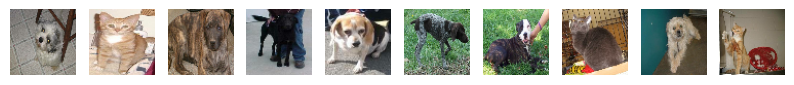

In [12]:
def imshow():
    n=10
    plt.figure(figsize=(10,6))
    for images,labels in dataset.take(1):
        for i in range(n):
            img=images[i]
            ax=plt.subplot(3,n,i+1+n)
            plt.imshow(img,cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
    plt.show()
imshow()

In [25]:
inputs=Input(shape=(64,64,3))
x=Reshape((64,64,3))(inputs)
x=Conv2D(32,3,activation='relu',padding='same')(x)
x=Conv2D(32,3,activation='relu',strides=2,padding='same')(x)
x=Conv2D(64,3,activation='relu',padding='same')(x)
x=Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x=Conv2D(128,3,activation='relu',padding='same')(x)
x=Conv2D(128,3,activation='relu',strides=2,padding='same')(x)
x=Conv2D(256,3,activation='relu',padding='same')(x)
x=Conv2D(512,3,activation='relu',padding='same')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(2,activation='sigmoid')(x)
outputs=x
cnn=keras.Model(inputs,outputs)

In [26]:
cnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       7385

In [27]:
class Model(tf.keras.Model):
    def __init__(self,nn):
        super(Model,self).__init__()
        self.nn=nn

    def get_loss(self,y,preds):
        loss=tf.keras.losses.CategoricalCrossentropy()(y,preds)
        return loss

    @tf.function
    def training_step(self,x,y):
        with tf.GradientTape() as tape:
            preds=self.nn(x)
            loss=self.get_loss(y,preds)
        gradients=tape.gradient(loss,self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.nn.trainable_variables))
        return tf.reduce_mean(loss)

In [28]:
model=Model(cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

In [29]:
for x,y in dataset.take(1):
    print(model.training_step(x,y))

tf.Tensor(0.6927629, shape=(), dtype=float32)


10


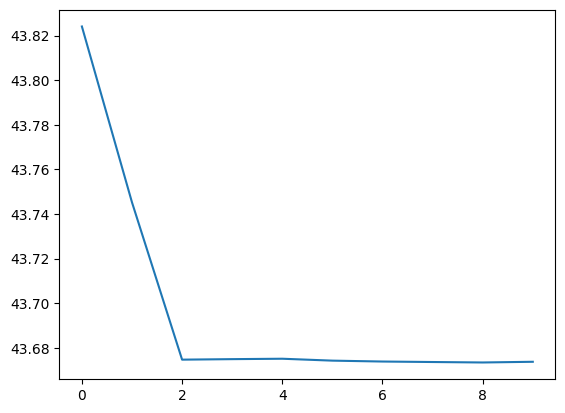

In [30]:
from IPython.display import clear_output
hist=np.array(np.empty([0]))
epochs = 10
for epoch in range(1,epochs + 1):
    loss = 0
    for step ,(x,y) in enumerate(dataset):
        loss+=model.training_step(x,y)
    clear_output(wait=True)
    print(epoch)
    hist=np.append(hist,loss)
    plt.plot(np.arange(0,len(hist)),hist)
    plt.show()

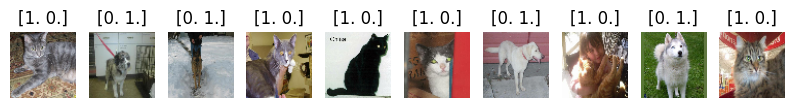

In [31]:
def imshow_and_pred():
    n=10
    plt.figure(figsize=(10,5))
    for images, labels in dataset.take(1):
        for i in range(n):
            img=images[i]
            img_tensor=tf.expand_dims(img,axis=0)
            pred=model.nn(img_tensor)
            pred=tf.squeeze(pred,axis=0)
            pred=pred.numpy()

            ax=plt.subplot(3,n,i+1+n)
            plt.imshow(img,cmap='gist_gray')

            plt.axis('off')
            plt.title(str(labels.numpy()[i]))
            ax.get_yaxis().set_visible(False)
    plt.show()

imshow_and_pred()

In [32]:
dataset=tf.keras.utils.image_dataset_from_directory(
    "train",
    labels='inferred',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)
normalization_layer=tf.keras.layers.Rescaling(1./255)
dataset=dataset.map(lambda x,y:(normalization_layer(x),tf.one_hot(y,2)))
AUTOTUNE=tf.data.AUTOTUNE
dataset=dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.


In [33]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224,224,3))
base_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [34]:
from keras.layers import BatchNormalization,Dropout
inputs=Input(shape=(224,224,3))
x=Reshape((224,224,3))(inputs)
x=base_model(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(512,activation="relu")(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(2,activation='sigmoid')(x)
outputs=x
cnn=keras.Model(inputs,outputs)

In [35]:
cnn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 reshape_2 (Reshape)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               6558

In [36]:
model=Model(cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

10


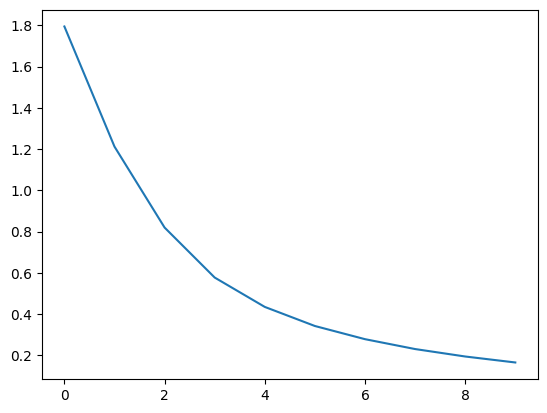

In [38]:
from IPython.display import clear_output
hist=np.array(np.empty([0]))
epochs = 10
for epoch in range(1,epochs + 1):
    loss = 0
    for step ,(x,y) in enumerate(dataset):
        loss+=model.training_step(x,y)
    clear_output(wait=True)
    print(epoch)
    hist=np.append(hist,loss)
    plt.plot(np.arange(0,len(hist)),hist)
    plt.show()

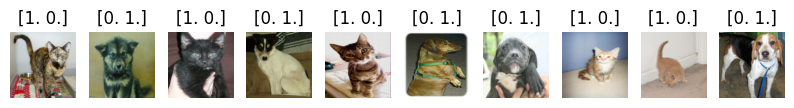

In [39]:
imshow_and_pred()

In [40]:
print("Number of layersin the base model ",len(base_model.layers))

Number of layersin the base model  154


In [41]:
base_model.trainable=True
fine_tune_at=100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

In [44]:
from keras.layers import BatchNormalization,Dropout
inputs=Input(shape=(224,224,3))
x=Reshape((224,224,3))(inputs)
x=base_model(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(512,activation="relu")(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(2,activation='sigmoid')(x)
outputs=x
cnn=keras.Model(inputs,outputs)

In [46]:
cnn.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 reshape_3 (Reshape)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               6558

In [42]:
model=Model(cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5))

10


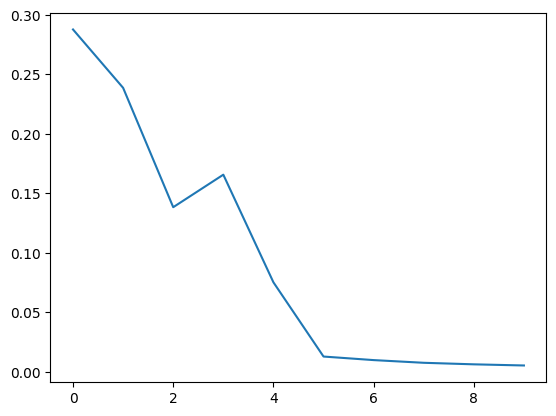

In [47]:
from IPython.display import clear_output
hist=np.array(np.empty([0]))
epochs = 10
for epoch in range(1,epochs + 1):
    loss = 0
    for step ,(x,y) in enumerate(dataset):
        loss+=model.training_step(x,y)
    clear_output(wait=True)
    print(epoch)
    hist=np.append(hist,loss)
    plt.plot(np.arange(0,len(hist)),hist)
    plt.show()

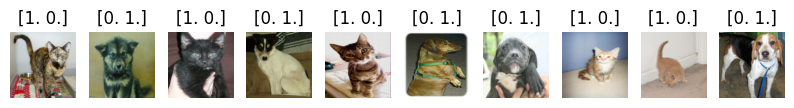

In [48]:
imshow_and_pred()

In [51]:
import cv2
cap=cv2.VideoCapture(1)

while(cap.isOpened()):
  ret,frame = cap.read()

  img_tensor=tf.expand_dims(frame,axis=0)
  img_tensor=tf.cast(img_tensor,tf.float32)/255
  img_tensor=tf.image.resize(img_tensor,(224,224),method='area')

  res=model.cnn(img_tensor)

  dog_bar=round(res.numpy()[0][0]*100)
  cat_bar=round(res.numpy()[0][1]*100)

  frame[20:30,20:20+dog_bar,:]=np.full((10,dog_bar,3),[100,100,100])
  frame[40:50,20:20+cat_bar,:]=np.full((10,cat_bar,3),[100,100,100])

  cv2.imshow('frame',frame)
  if cv2.waitkey(1) == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

In [52]:
model.nn.save('cnn_model_h5')